# Remove Photobleaching

**Main function: photob_remove(** *video, time, mask, ROIs_means, transitory, t_sig_onset=None, t_sig_end=None* **)**

Return ROIs means corrected for photobleaching by best curve fit, an array mask indicating signal inactive intervals and time instants when signal starts and ends.

If not provided, estimates time instants when signal starts and ends, creating an array that represents time instants when signal is absent. Then, for each signal observation, subtracts a decreasing function representing photobleaching. Such function is obtained by best curve fit ([SciPy curve_fit function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)) using a combination of exponential and linear (and step if transitory=*False*) functions. 

**Parameters:**  
- **video: array**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **time: array**
    - (F,) array, where F are time points.
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **transitory: bool or NoneType**
    - transitory=*True* if signal is transitory. transitory=*False* if signal is perduring (like a step). transitory=*None* if no signal is present.
- **t_sig_onset: float, optional**
    - time instant (in seconds) when signal is supposed to start. If *None*, it will be estimated by highest first derivative instant.
- **t_sig_end: float, optional**
    - time instant (in seconds) when signal is supposed to end. If *None*, it will be estimated by t_sig_onset + duration while signal amplitude remains bigger than twice the noise standard deviation (which is estimated from instants before t_sig_onset).
 
**Returns:**  ROIs_means_corrected, inactive_msk, t_sig_onset, t_sig_end
- **ROIs_means_corrected: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **inactive_msk: boolean array**
    - (F) boolean array, where F are frames.
- **t_sig_onset: float, optional**
    - time instant (in seconds) when signal is supposed to start.
- **t_sig_end: float, optional**
    - time instant (in seconds) when signal is supposed to end.

In [1]:
testing = (__name__ == "__main__")
if testing:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    rpbpath = os.path.abspath('')
    items = os.listdir(rpbpath)
    if rpbpath not in sys.path:
        sys.path.append(rpbpath)
    if 'MESS.py' not in items:
        ! jupyter nbconvert --to 'python' MESS.ipynb
    import MESS as mes

## Mandatory Parameters:

In [2]:
if testing:
    from skimage import io
    fpath = os.path.join('Data','Cell1','videos_AP')
    fr = 55.78
    
    fname = 'vid1.tif'
    fullpath = os.path.join(fpath,fname)
    video = io.imread(fullpath)
    
    mname = 'cellmask.tif'
    fullpath = os.path.join(fpath,mname)
    mask = io.imread(fullpath)
    
    transitory=True    

## Optional Parameters:

In [3]:
if testing:
    t_sig_onset_0=0.5
    t_sig_end_0=1


## Apply MESS:

In [4]:
if testing:
    ROIs_masks, label_ROIs, ROIs_means, time  = mes.segment(mask, video, fr)

## Remove_Photobleaching functions:

In [5]:
def guess_t_sig_onset(vmean,time):
    '''Returns time and correspondig index where absolute maximum derivative is found, indicating signal rise/fall time'''
    import numpy as np
    d_vmean = abs(np.diff(vmean))
    dmax_idx = np.argmax(d_vmean) +1
    t_sig_onset = time[dmax_idx]  
    return(t_sig_onset, dmax_idx)

In [6]:
def guess_t_sig_duration(vmean, time, t_sig_onset_idx):
    '''Returns indices of time vector later then t_sig_onset and when they are bigger than channel background noise'''
    import numpy as np
    noise_threshold = 2*np.std(vmean[:t_sig_onset_idx])
    t_sig_active = np.empty_like(vmean,dtype=bool)
    t_sig_active = np.where(abs(vmean)>noise_threshold,True,False)
    t_sig_active[:t_sig_onset_idx] = False
    i=t_sig_onset_idx
    while(t_sig_active[i]==True):
        i+=1
    t_sig_end_idx = i
    return(time[t_sig_end_idx],t_sig_end_idx) 

In [7]:
def guess_t_sig_prop(video,time,mask,transitory,t_sig_onset=None):
    '''Tries to find where signal starts and its duration by cell mask mean over time'''
    from scipy.signal import detrend
    import numpy as np
    video_masked = video*mask
    video_masked_mean = np.mean(video_masked,axis=(1,2))
    
    video_masked_mean_detrend = detrend(video_masked_mean,type='linear')
    if t_sig_onset is None:
        t_sig_onset, t_sig_onset_idx = guess_t_sig_onset(video_masked_mean_detrend,time)
    else:
        t_sig_onset_idx = np.argmin(abs(time-t_sig_onset))
    
    if transitory==True:
        t_sig_end,t_sig_end_idx = guess_t_sig_duration(video_masked_mean_detrend, time, t_sig_onset_idx)

        if t_sig_onset==t_sig_end:
            t_sig_end=None
        return(t_sig_onset, t_sig_onset_idx, t_sig_end)
    else:
        return(t_sig_onset, t_sig_onset_idx,None)

In [8]:
def create_inactive_idx_msk(video,time,mask,transitory=False,t_sig_onset=None,t_sig_end=None):
    '''Create vector masks indicating time periods of inactivity, i.e., where only noise is present'''
    import numpy as np
    #If there is no information about signal start, try to estimate from mean from cellmasked video
    if transitory==None:
        idx_msk = np.ones_like(time,dtype=bool)
        return(idx_msk,t_sig_onset,t_sig_end)
    
    if transitory==False:
        t_sig_end=None
        if (t_sig_onset==None):
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory)
            
    if transitory==True:
        if (t_sig_onset==None):
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory)
        elif t_sig_end is None:
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory,t_sig_onset)
            if t_sig_onset==t_sig_end:
                t_sig_end = None

    if t_sig_end is None:
        idx_msk = ((time>0) & (time<t_sig_onset-0.1))
    else:
        idx_msk = ((time>0) & (time<t_sig_onset-0.1)) | ((time>t_sig_end))

    return(idx_msk,t_sig_onset,t_sig_end)

In [9]:
def monoexp(x, a, b, d):
    import numpy as np
    return a * np.exp(-b * x) + d

In [10]:
def monoexp_and_line(x, a, b, c, d):
    import numpy as np
    return a * np.exp(-b * x) - (c * x) + d

In [11]:
def monoexp_line_step(x, a, b, c, d, e,t_sig_onset): 
    import numpy as np
    return a * np.exp(-b * x) - (c * x) + d - e * (np.sign(x-t_sig_onset) + 1)

In [12]:
def monoexp_step(x, a, b, d, e,t_sig_onset): 
    import numpy as np
    return a * np.exp(-b * x) + d - e * (np.sign(x-t_sig_onset) + 1)

In [21]:
def photob_fit(ROIs_means,time,idx_msk,transitory,t_sig_onset):
    import numpy as np
    from scipy.optimize import curve_fit
    from scipy.stats import linregress
    steps = np.empty(ROIs_means.shape[1])
    corrected = np.empty(ROIs_means.shape)
    #Runs over the ROIs
    for j in range(ROIs_means.shape[1]):
        #Photobleaching is taken from inactivity intervals
        photobleaching = ROIs_means[idx_msk,j]

        #Tries different fit functions:
        #  1. Linear (just to get an estimative for curve_fit parameters)
        #  2. Monoexponential + linear for AP signals
        #  3. Monoexponential + linear + step (just for step-like signal)

        y0 = np.mean(photobleaching[0:5])
        yf = np.mean(photobleaching[-5:])
        #FIT #1:    linear fit
        c, d, r_value, p_value, std_err= linregress(time[idx_msk],photobleaching)
#         c, d = np.polyfit(time[idx_msk],photobleaching,1)
        p = np.poly1d([c,d])
        #Calculate residues
        res_linear = photobleaching - p(time[idx_msk])
        total_res_linear = np.sum(abs(res_linear**2))/len(photobleaching)
        
        #Assures y0 is bigger than yf for proper upper boundaries calculation
        if yf>=y0:
            if d>yf:
                y0 = d
            else:
                y0 = yf + 1
                
        #If transitory signal
        if ((transitory==True) | (transitory==None)):
            #FIT #2:    monoexp and line fit
            upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*(abs(c)), 2*yf]
            popt2, pcov2 = curve_fit(monoexp_and_line, time[idx_msk], photobleaching, bounds=(0, upper_bounds))
            res_expline = photobleaching - monoexp_and_line(time[idx_msk], *popt2)
            total_res_expline = np.sum(abs(res_expline**2))/len(photobleaching)

            #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit   
            if np.all(np.greater(upper_bounds,popt2+0.01*(popt2)))==False:
                clip_flag = 1
                while(clip_flag==1):
                    close = np.isclose(upper_bounds,popt2,atol=1e-02)
                    if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
                        upper_bounds = np.multiply(2,upper_bounds)
                    else:                     #if clipped parameter is identified, duplicate it
                        closeidx = np.argwhere(close)[0][0]
                        upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
                    popt2, pcov2 = curve_fit(monoexp_and_line, time[idx_msk], photobleaching, bounds=(0, upper_bounds))
                    res_expline = photobleaching - monoexp_and_line(time[idx_msk], *popt2)
                    total_res_expline = np.sum(abs(res_expline**2))/len(photobleaching)
                    if np.all(np.greater(upper_bounds,popt2+0.01*(popt2)))==True:
                        clip_flag = 0
                    #Breaks if either exponential coefficient or linear coefficients "overflow"
                    if (popt2[0]+popt2[3]>1.2*y0)|(popt2[1]<0.05):
                        break
        #If step-like signal, perform fits including step
        #Inputs include whole data
        if transitory==False:
            #FIT #5:     monoexp, line and step fit
            upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*(abs(c)), 2*yf, (y0-yf)]
            popt3, pcov3 = curve_fit(lambda x, a, b, c, d, e: monoexp_line_step(x,a,b,c,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
            res_explinestep = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
            total_res_explinestep = np.sum(abs(res_explinestep**2))/len(ROIs_means[:,j])
            #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit 
            if np.all(np.greater(upper_bounds,popt3+0.01*(popt3)))==False:
                clip_flag = 1
                while(clip_flag==1):
                    close = np.isclose(upper_bounds,popt3,atol=1e-02)
                    if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
                        upper_bounds = np.multiply(2,upper_bounds)
                    else:
                        closeidx = np.argwhere(close)[0][0]
                        upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
                    popt3, pcov3 = curve_fit(lambda x, a, b, c, d, e: monoexp_line_step(x,a,b,c,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
                    res_explinestep = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
                    total_res_explinestep = np.sum(abs(res_explinestep**2))/len(ROIs_means[:,j])
                    if np.all(np.greater(upper_bounds,popt3+0.01*(popt3)))==True:
                        clip_flag = 0
                    #Breaks if either exponential coefficient or linear coefficients "overflow"
                    if (popt3[0]+popt3[3]>1.2*y0)|(popt3[1]<0.05):
                        break

        #subtracts fit
        if ((transitory==True) | (transitory==None)):
            corrected[:,j] = ROIs_means[:,j] - monoexp_and_line(time, *popt2)
        else:
            #exclude step in order to leave just photobleaching
            steps[j] = np.copy(-2*popt3[-1])
            popt3[-1] = 0
            corrected[:,j] = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
        #First frame gets median to avoid some cases where exponential function is assigned almost exclusevely to the first frame 
        corrected[0,:] = np.mean(corrected[idx_msk,:],axis=0)

        corrections=None #obsolete
    return(corrected, corrections)

# Main Function:

In [22]:
def photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset=None,t_sig_end=None):
    #Create vector masks indicating time periods of inactivity
    inactive_msk,t_sig_onset,t_sig_end = create_inactive_idx_msk(video,time,mask,transitory,t_sig_onset=t_sig_onset,t_sig_end=t_sig_end)

    ROIs_means_corrected, corrections = photob_fit(ROIs_means,time,inactive_msk,transitory,t_sig_onset)
    
    return(ROIs_means_corrected, inactive_msk, t_sig_onset, t_sig_end)

# Test

In [23]:
if testing:
    ROIs_means_corrected, inactive_msk,t_sig_onset,t_sig_end  = photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset_0,t_sig_end_0)

# Time of main function execution:

In [16]:
if testing:
    %timeit ROIs_means_corrected, inactive_msk,t_sig_onset,t_sig_end  = photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset_0,t_sig_end_0)

336 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot results

In [24]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

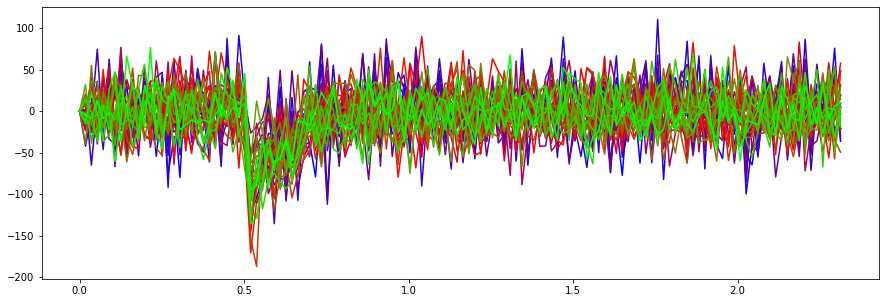

In [25]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_corrected[:,i],color=newcolors[i+1])

In [26]:
if testing:
    print('Signal onset time:',t_sig_onset,'s')
    print('Signal end time:',t_sig_end,'s')

Signal onset time: 0.5 s
Signal end time: 1 s
